In [2]:
"""
UHID Essex County - Land Surface Temperature Analysis
Author: Samuel
Date: November 2025
Purpose: Process existing Landsat thermal imagery to extract LST hotspots

This notebook:
1. Loads pre-downloaded Landsat data from Google Drive
2. Processes thermal bands to Land Surface Temperature
3. Creates hotspot maps
4. Exports processed temperature grids
"""
print("Notebook: 01_LST_Analysis.ipynb loaded.")


Notebook: 01_LST_Analysis.ipynb loaded.


In [3]:
# ============================================
# SETUP - Mount Drive and Navigate
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SharedFilesUHIDTeam')

print("✓ Drive mounted and navigated to data folder")

Mounted at /content/drive
✓ Drive mounted and navigated to data folder


In [4]:
# ============================================
# INSTALL & IMPORT LIBRARIES
# ============================================
print("\n=== Installing Required Packages ===")
!pip install rasterio geopandas matplotlib numpy scipy -q

import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages loaded")



=== Installing Required Packages ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 94.0 MB/s eta 0:00:00
✓ All packages loaded


In [5]:
# ============================================
# STEP 1: EXPLORE LANDSAT DATA FOLDER
# ============================================
print("\n=== Checking Landsat Data Folder ===")

lst_folder = Path('01_Satellite_LST')

# List all files in the folder
if lst_folder.exists():
    files = list(lst_folder.glob('*'))
    print(f"✓ Found {len(files)} files in 01_Satellite_LST/")
    print("\nFiles:")
    for f in files[:20]:  # Show first 20 files
        print(f"  - {f.name} ({f.stat().st_size / 1e6:.1f} MB)")

    if len(files) > 20:
        print(f"  ... and {len(files) - 20} more files")
else:
    print("✗ 01_Satellite_LST folder not found!")


=== Checking Landsat Data Folder ===
✓ Found 1 files in 01_Satellite_LST/

Files:
  - Essex_County_LST_Summer_2023.tif (3.7 MB)


In [6]:
# ============================================
# STEP 2: IDENTIFY THERMAL BAND FILES
# ============================================
print("\n=== Identifying Thermal Band Files ===")

# Landsat thermal bands are typically:
# - Landsat 8/9: Band 10 (B10) - 100m resolution
# - File naming: LC08_...B10.TIF or LC09_...B10.TIF

thermal_files = []
for pattern in ['*B10*.TIF', '*B10*.tif', '*thermal*.tif', '*LST*.tif']:
    thermal_files.extend(list(lst_folder.glob(pattern)))

if thermal_files:
    print(f"✓ Found {len(thermal_files)} thermal band file(s)")
    for tf in thermal_files:
        print(f"  - {tf.name}")
else:
    print(" No thermal bands found with standard naming")
    print("\nPlease check file naming pattern. Looking for files containing:")
    print("  - 'B10' (Landsat Band 10)")
    print("  - 'thermal'")
    print("  - 'LST'")



=== Identifying Thermal Band Files ===
✓ Found 1 thermal band file(s)
  - Essex_County_LST_Summer_2023.tif


In [7]:
# ============================================
# STEP 3: LOAD AND INSPECT THERMAL DATA
# ============================================
print("\n=== Loading Thermal Data ===")

# Use the first thermal file found (adjust if multiple dates)
if thermal_files:
    thermal_file = thermal_files[0]

    with rasterio.open(thermal_file) as src:
        print(f"\n📊 Raster Properties:")
        print(f"  File: {thermal_file.name}")
        print(f"  CRS: {src.crs}")
        print(f"  Dimensions: {src.width} x {src.height} pixels")
        print(f"  Resolution: {src.res[0]:.2f} x {src.res[1]:.2f} meters")
        print(f"  Bounds: {src.bounds}")
        print(f"  Data type: {src.dtypes[0]}")
        print(f"  NoData value: {src.nodata}")

        # Read the thermal band
        thermal_band = src.read(1)

        print(f"\n📈 Data Statistics:")
        print(f"  Min value: {np.nanmin(thermal_band):.2f}")
        print(f"  Max value: {np.nanmax(thermal_band):.2f}")
        print(f"  Mean value: {np.nanmean(thermal_band):.2f}")
        print(f"  Valid pixels: {np.sum(~np.isnan(thermal_band)):,}")


=== Loading Thermal Data ===

📊 Raster Properties:
  File: Essex_County_LST_Summer_2023.tif
  CRS: EPSG:32618
  Dimensions: 664 x 667 pixels
  Resolution: 30.00 x 30.00 meters
  Bounds: BoundingBox(left=559305.0, bottom=4499115.0, right=579225.0, top=4519125.0)
  Data type: float64
  NoData value: None

📈 Data Statistics:
  Min value: 19.71
  Max value: 58.20
  Mean value: 36.21
  Valid pixels: 442,888


In [10]:
# ============================================
# STEP 4: LOAD LST DATA (Already in Celsius)
# ============================================
print("\n=== Loading Land Surface Temperature Data ===")

if thermal_files:
    with rasterio.open(thermal_file) as src:
        # Data is already in Celsius - just load it
        lst_celsius = src.read(1).astype(float)
        profile = src.profile

        # Replace any zero or invalid values with NaN
        lst_celsius[lst_celsius == 0] = np.nan
        lst_celsius[(lst_celsius < 0) | (lst_celsius > 70)] = np.nan

        print(f"\n🌡️ LST Statistics (°C):")
        print(f"  Valid pixels: {np.sum(~np.isnan(lst_celsius)):,}")
        print(f"  Min temperature: {np.nanmin(lst_celsius):.2f}°C")
        print(f"  Max temperature: {np.nanmax(lst_celsius):.2f}°C")
        print(f"  Mean temperature: {np.nanmean(lst_celsius):.2f}°C")
        print(f"  Median temperature: {np.nanmedian(lst_celsius):.2f}°C")
        print(f"  Std deviation: {np.nanstd(lst_celsius):.2f}°C")

        print(f"\n✓ Data already calibrated to Celsius - ready for analysis!")


=== Loading Land Surface Temperature Data ===

🌡️ LST Statistics (°C):
  Valid pixels: 442,888
  Min temperature: 19.71°C
  Max temperature: 58.20°C
  Mean temperature: 36.21°C
  Median temperature: 38.23°C
  Std deviation: 5.74°C

✓ Data already calibrated to Celsius - ready for analysis!


In [13]:
# ============================================
# STEP 5: IDENTIFY HEAT HOTSPOTS
# ============================================
print("\n=== Identifying Urban Heat Island Hotspots ===")

if thermal_files:
    # Calculate temperature anomaly (deviation from mean)
    mean_temp = np.nanmean(lst_celsius)
    temp_anomaly = lst_celsius - mean_temp

    # Define hotspot categories
    # Extreme: >3°C above mean
    # High: 2-3°C above mean
    # Moderate: 1-2°C above mean
    # Normal: ±1°C from mean
    # Cool: <-1°C below mean

    hotspot_classes = np.zeros_like(lst_celsius)
    hotspot_classes = np.where(temp_anomaly > 3, 5, hotspot_classes)  # Extreme
    hotspot_classes = np.where((temp_anomaly > 2) & (temp_anomaly <= 3), 4, hotspot_classes)  # High
    hotspot_classes = np.where((temp_anomaly > 1) & (temp_anomaly <= 2), 3, hotspot_classes)  # Moderate
    hotspot_classes = np.where((temp_anomaly >= -1) & (temp_anomaly <= 1), 2, hotspot_classes)  # Normal
    hotspot_classes = np.where(temp_anomaly < -1, 1, hotspot_classes)  # Cool
    hotspot_classes = np.where(np.isnan(lst_celsius), 0, hotspot_classes)  # NoData

    # Calculate area statistics
    pixel_area = src.res[0] * src.res[1]  # m²

    print(f"\n📊 Hotspot Distribution:")
    for i, category in enumerate(['NoData', 'Cool (<-1°C)', 'Normal (±1°C)',
                                    'Moderate (+1-2°C)', 'High (+2-3°C)',
                                    'Extreme (>+3°C)']):
        count = np.sum(hotspot_classes == i)
        area_km2 = (count * pixel_area) / 1e6
        percent = (count / hotspot_classes.size) * 100
        if i > 0:  # Skip NoData in display
            print(f"  {category}: {area_km2:.2f} km² ({percent:.1f}%)")


=== Identifying Urban Heat Island Hotspots ===

📊 Hotspot Distribution:
  Cool (<-1°C): 124.54 km² (31.2%)
  Normal (±1°C): 44.00 km² (11.0%)
  Moderate (+1-2°C): 30.12 km² (7.6%)
  High (+2-3°C): 44.29 km² (11.1%)
  Extreme (>+3°C): 155.64 km² (39.0%)



=== Creating Visualizations ===
✓ Visualization saved: LST_Analysis_Essex_County.png


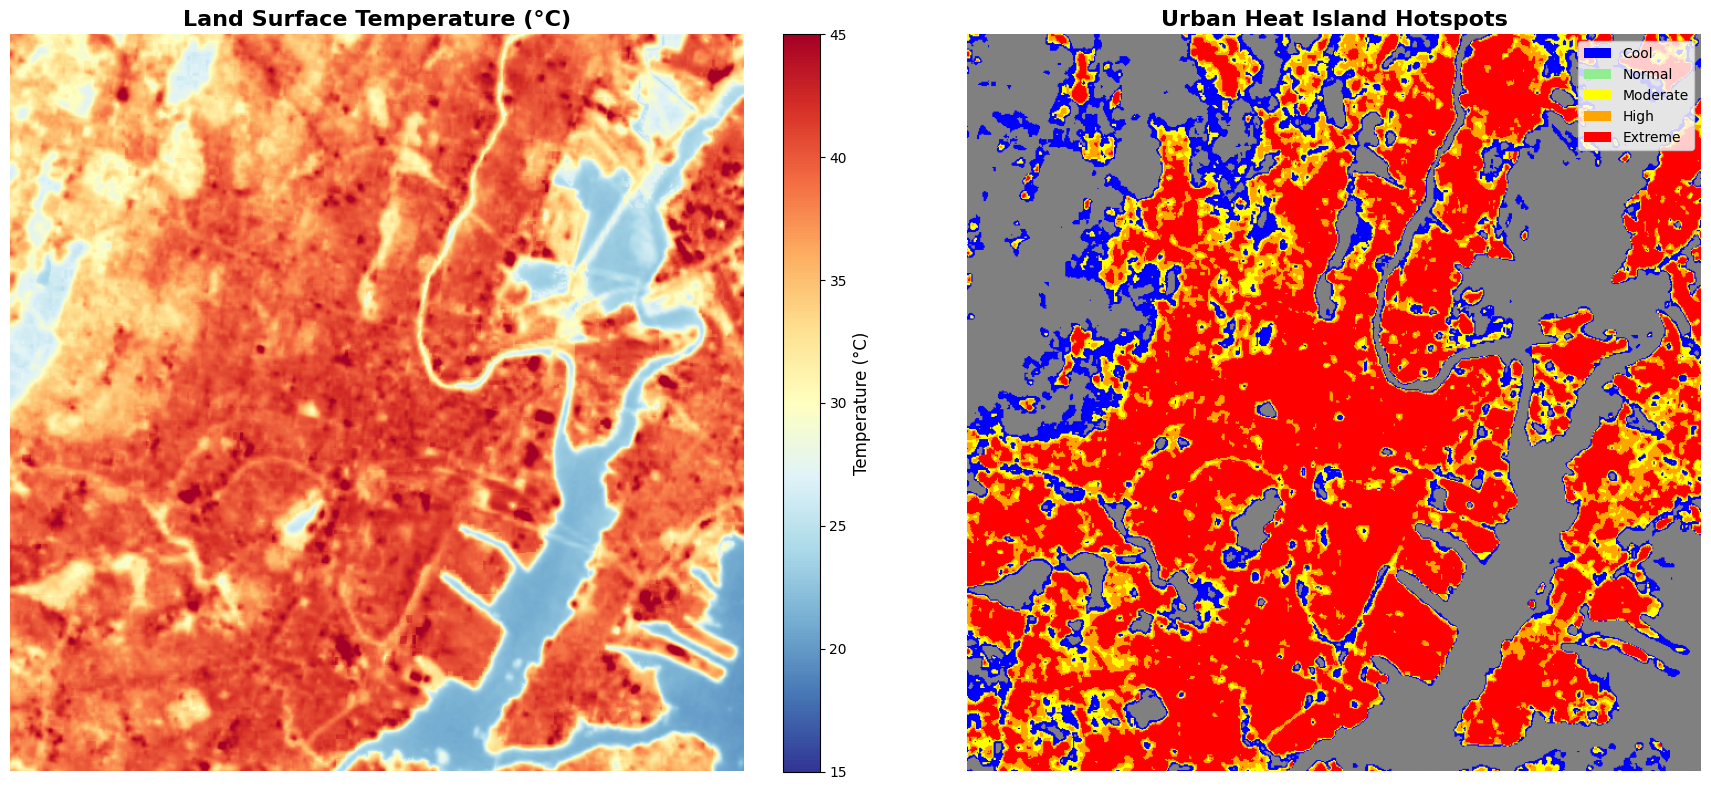

In [14]:
# ============================================
# STEP 6: VISUALIZE LST AND HOTSPOTS
# ============================================
print("\n=== Creating Visualizations ===")

if thermal_files:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Land Surface Temperature
    im1 = axes[0].imshow(lst_celsius, cmap='RdYlBu_r', vmin=15, vmax=45)
    axes[0].set_title('Land Surface Temperature (°C)', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Temperature (°C)', fontsize=12)

    # Plot 2: Hotspot Classification
    colors = ['gray', 'blue', 'lightgreen', 'yellow', 'orange', 'red']
    im2 = axes[1].imshow(hotspot_classes, cmap=plt.cm.colors.ListedColormap(colors))
    axes[1].set_title('Urban Heat Island Hotspots', fontsize=16, fontweight='bold')
    axes[1].axis('off')

    # Custom legend
    from matplotlib.patches import Patch
    legend_labels = ['Cool', 'Normal', 'Moderate', 'High', 'Extreme']
    legend_colors = colors[1:]  # Skip NoData color
    legend_patches = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
    axes[1].legend(handles=legend_patches, loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.savefig('LST_Analysis_Essex_County.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved: LST_Analysis_Essex_County.png")
    plt.show()

In [15]:
# ============================================
# STEP 7: EXPORT PROCESSED DATA
# ============================================
print("\n=== Exporting Processed Data ===")

if thermal_files:
    # Create output folder
    output_folder = Path('01_Satellite_LST/processed')
    output_folder.mkdir(exist_ok=True)

    # Update profile for output
    profile.update(
        dtype=rasterio.float32,
        count=1,
        nodata=-9999
    )

    # Replace NaN with nodata value
    lst_export = np.where(np.isnan(lst_celsius), -9999, lst_celsius)
    hotspot_export = np.where(hotspot_classes == 0, -9999, hotspot_classes)

    # Export LST raster
    with rasterio.open(output_folder / 'Essex_LST_Celsius.tif', 'w', **profile) as dst:
        dst.write(lst_export.astype(rasterio.float32), 1)
    print("✓ Exported: Essex_LST_Celsius.tif")

    # Export hotspot classification
    with rasterio.open(output_folder / 'Essex_Hotspot_Classification.tif', 'w', **profile) as dst:
        dst.write(hotspot_export.astype(rasterio.float32), 1)
    print("✓ Exported: Essex_Hotspot_Classification.tif")

    # Export summary statistics as CSV
    stats_df = pd.DataFrame({
        'Metric': ['Min Temp (°C)', 'Max Temp (°C)', 'Mean Temp (°C)',
                   'Median Temp (°C)', 'Std Dev (°C)'],
        'Value': [np.nanmin(lst_celsius), np.nanmax(lst_celsius),
                  np.nanmean(lst_celsius), np.nanmedian(lst_celsius),
                  np.nanstd(lst_celsius)]
    })
    stats_df.to_csv(output_folder / 'LST_Statistics.csv', index=False)
    print("✓ Exported: LST_Statistics.csv")



=== Exporting Processed Data ===
✓ Exported: Essex_LST_Celsius.tif
✓ Exported: Essex_Hotspot_Classification.tif
✓ Exported: LST_Statistics.csv
